In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential 
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
# dataset paths
csv_path_train = '..\Datasets\sign_mnist_train\sign_mnist_train.csv'
csv_path_test = '..\Datasets\sign_mnist_test\sign_mnist_test.csv'

In [4]:
# loading data
train_df = pd.read_csv(csv_path_train)
test_df = pd.read_csv(csv_path_test)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


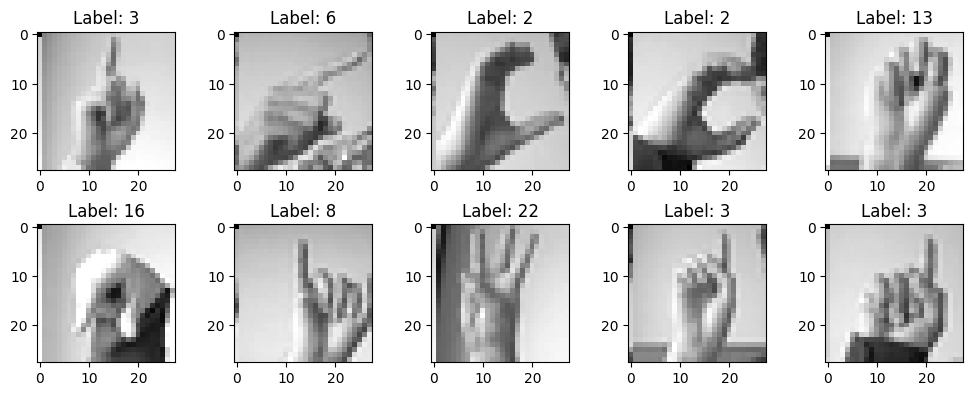

In [8]:
# plotting the data
pixels = train_df.iloc[:, :-1].values
labels = train_df['label'].values

num_rows = 2
num_cols = 5


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4))

num_images_to_visualize = 10
for i in range(num_images_to_visualize):
    row = i // num_cols
    col = i % num_cols
    image = pixels[i].reshape(28, 28)
    
    label = labels[i]
    axes[row, col].set_title(f"Label: {label}")
    
    axes[row, col].imshow(image, cmap='gray')

for i in range(num_images_to_visualize, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

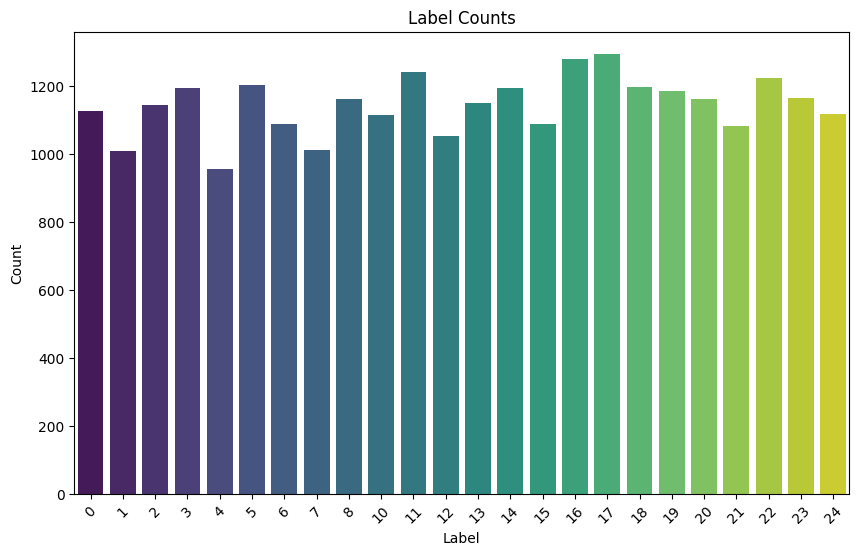

In [9]:
label_counts = train_df['label'].value_counts().sort_index()
cmap = sns.color_palette("viridis", n_colors=len(label_counts))

# Create a bar plot with gradient colors using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette=cmap, legend=False)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.xticks(rotation=45)  # Optionally, rotate the x-axis labels for better readability
plt.show()

In [23]:
label_counts.values

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162, 1114, 1241,
       1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082, 1225,
       1164, 1118], dtype=int64)

In [28]:
np.mean(label_counts.values)

1143.9583333333333

From this we can see that we have suuficent lables in each class which helps in training

In [9]:
y_train = train_df['label']
y_test = test_df['label']
x_train= train_df.iloc[:, :-1].values
x_test = test_df.iloc[:, :-1].values

In [10]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [11]:
x_train.shape

(27455, 784)

In [12]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [13]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [14]:
x_train.shape

(27455, 28, 28, 1)

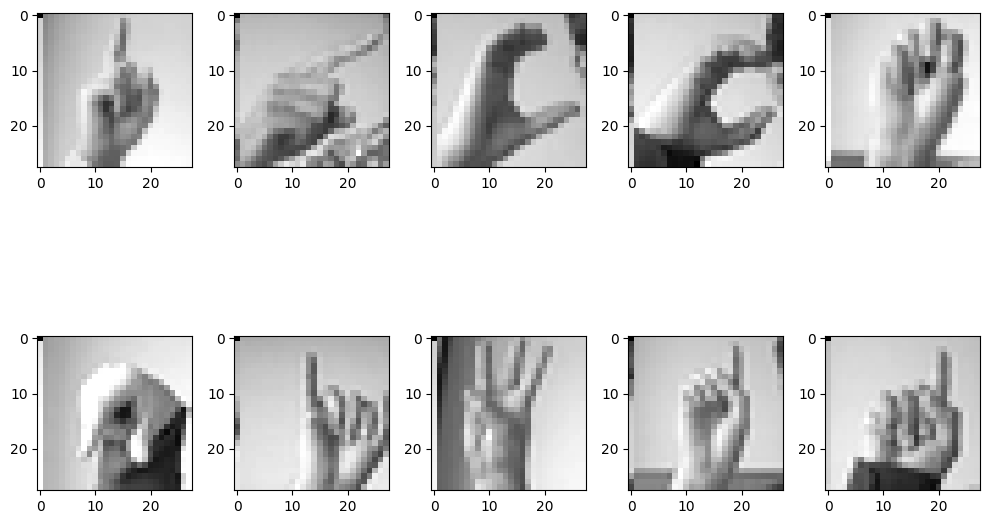

In [37]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [15]:
datagen = ImageDataGenerator( 
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

Model1


In [72]:
model = Sequential()
model.add(Conv2D(20 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

In [75]:
model.compile(optimizer=Adam(learning_rate=0.02) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 20)        200       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 20)       80        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 20)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 980)               0         
                                                      

In [76]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 9s 37ms/step - loss: 0.6479 - accuracy: 0.7906 - val_loss: 3.0539 - val_accuracy: 0.3889 - lr: 0.0200
Epoch 2/10
215/215 [==============================] - 8s 35ms/step - loss: 0.5268 - accuracy: 0.8286 - val_loss: 0.7319 - val_accuracy: 0.7514 - lr: 0.0200
Epoch 3/10
215/215 [==============================] - 7s 35ms/step - loss: 0.4988 - accuracy: 0.8354 - val_loss: 0.6240 - val_accuracy: 0.7574 - lr: 0.0200
Epoch 4/10
215/215 [==============================] - 8s 35ms/step - loss: 0.5031 - accuracy: 0.8358 - val_loss: 0.3416 - val_accuracy: 0.8719 - lr: 0.0200
Epoch 5/10
215/215 [==============================] - 7s 34ms/step - loss: 0.4930 - accuracy: 0.8460 - val_loss: 0.2922 - val_accuracy: 0.8950 - lr: 0.0200
Epoch 6/10
215/215 [==============================] - 8s 35ms/step - loss: 0.4495 - accuracy: 0.8569 - val_loss: 0.5437 - val_accuracy: 0.8063 - lr: 0.0200
Epoch 7/10
215/215 [==============================] - 7s 35ms/st

In [17]:
#function for plotting the training and validation curves
def plotTrainCurves(output):
    # Extract loss and accuracy history
    train_loss = output.history['loss']
    val_loss = output.history['val_loss']
    train_accuracy = output.history['accuracy']
    val_accuracy = output.history['val_accuracy']
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

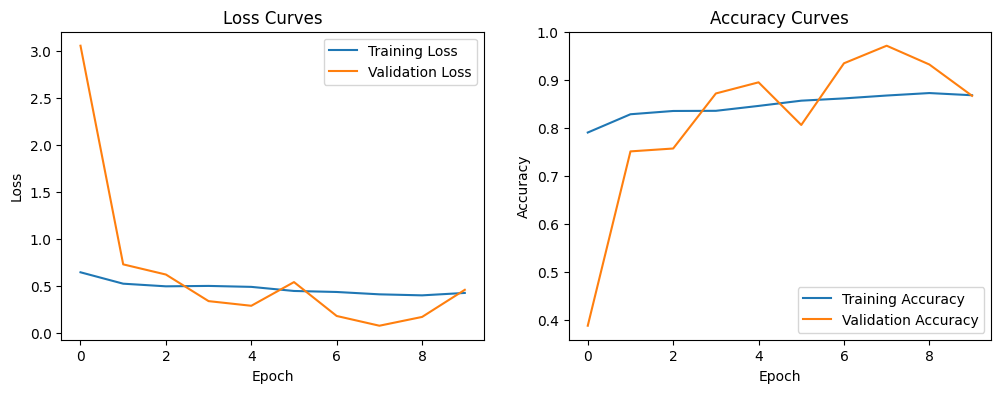

In [78]:
plotTrainCurves(history)

In [86]:
model.save("./models/model1.h5")

In [79]:
predictions1 = model.predict(x_test)
predicted_labels1 = np.argmax(predictions1, axis=1)

225/225 [==============================] - 1s 2ms/step


In [82]:
for i in range(len(predicted_labels1)):
    if predicted_labels1[i] > 8:
        predicted_labels1[i]+=1
print(predicted_labels1)

[ 6  5 10 ...  2  4  2]


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       331
           1       0.92      0.95      0.94       432
           2       0.94      1.00      0.97       310
           3       0.96      0.67      0.79       245
           4       0.99      0.90      0.94       498
           5       0.85      1.00      0.92       247
           6       0.98      0.69      0.81       348
           7       0.98      0.85      0.91       436
           8       0.71      1.00      0.83       288
          10       0.86      0.98      0.92       331
          11       0.94      0.99      0.96       209
          12       0.85      0.74      0.79       394
          13       0.97      0.88      0.92       291
          14       1.00      0.87      0.93       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.66      0.38      0.48

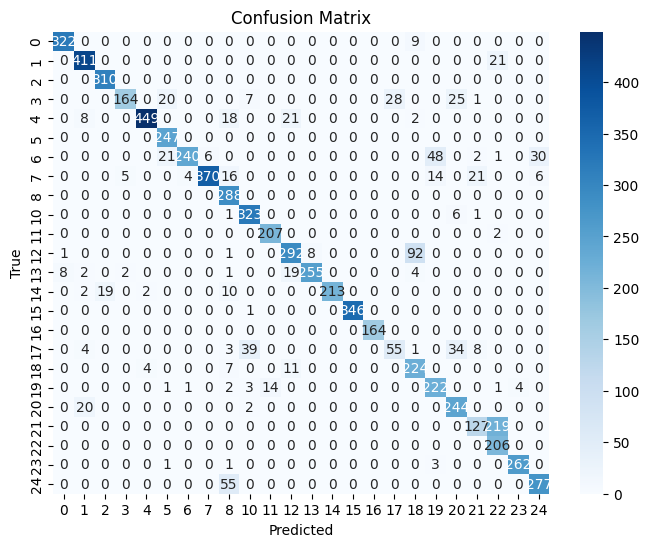

In [85]:
true_labels1 = np.array(test_df['label'])
accuracy1 = accuracy_score(true_labels1, predicted_labels1)
cm1 = confusion_matrix(true_labels1, predicted_labels1)
print(f'Accuracy: {accuracy1:.2f}')
class_labels1 = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_rep1 = classification_report(true_labels1, predicted_labels1)
print(f'Classification Report:\n{classification_rep1}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels1, yticklabels=class_labels1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model2

In [99]:
model2 = Sequential()
model2.add(Conv2D(20 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(10 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Flatten())
model2.add(Dense(units = 512 , activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(units = 24 , activation = 'softmax'))

In [102]:
model2.compile(optimizer=Adam(learning_rate=0.02) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 20)        200       
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 20)       80        
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 10)        1810      
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 10)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 10)     

In [103]:
history2 = model2.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 9s 38ms/step - loss: 0.3358 - accuracy: 0.8941 - val_loss: 0.4562 - val_accuracy: 0.8589 - lr: 0.0200
Epoch 2/10
215/215 [==============================] - 8s 36ms/step - loss: 0.3147 - accuracy: 0.9027 - val_loss: 0.2847 - val_accuracy: 0.8945 - lr: 0.0200
Epoch 3/10
215/215 [==============================] - 8s 35ms/step - loss: 0.2906 - accuracy: 0.9113 - val_loss: 0.1786 - val_accuracy: 0.9479 - lr: 0.0200
Epoch 4/10
215/215 [==============================] - 8s 36ms/step - loss: 0.2942 - accuracy: 0.9136 - val_loss: 0.2520 - val_accuracy: 0.9274 - lr: 0.0200
Epoch 5/10
215/215 [==============================] - 8s 35ms/step - loss: 0.3210 - accuracy: 0.9108 - val_loss: 0.1434 - val_accuracy: 0.9571 - lr: 0.0200
Epoch 6/10
215/215 [==============================] - 8s 35ms/step - loss: 0.2505 - accuracy: 0.9270 - val_loss: 0.1008 - val_accuracy: 0.9637 - lr: 0.0200
Epoch 7/10
215/215 [==============================] - 8s 35ms/st

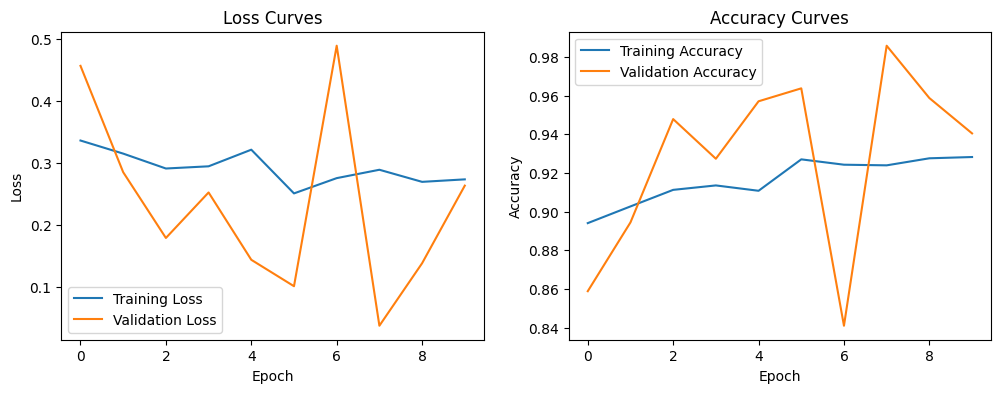

In [104]:
plotTrainCurves(history2)

In [105]:
model2.save("./models/model2.h5")

In [106]:
predictions2 = model.predict(x_test)
predicted_labels2 = np.argmax(predictions2, axis=1)

225/225 [==============================] - 1s 3ms/step


In [107]:
for i in range(len(predicted_labels2)):
    if predicted_labels2[i] > 8:
        predicted_labels2[i]+=1
print(predicted_labels1)

[ 6  5 10 ...  2  4  2]


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       331
           1       0.92      0.95      0.94       432
           2       0.94      1.00      0.97       310
           3       0.96      0.67      0.79       245
           4       0.99      0.90      0.94       498
           5       0.85      1.00      0.92       247
           6       0.98      0.69      0.81       348
           7       0.98      0.85      0.91       436
           8       0.71      1.00      0.83       288
          10       0.86      0.98      0.92       331
          11       0.94      0.99      0.96       209
          12       0.85      0.74      0.79       394
          13       0.97      0.88      0.92       291
          14       1.00      0.87      0.93       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.66      0.38      0.48

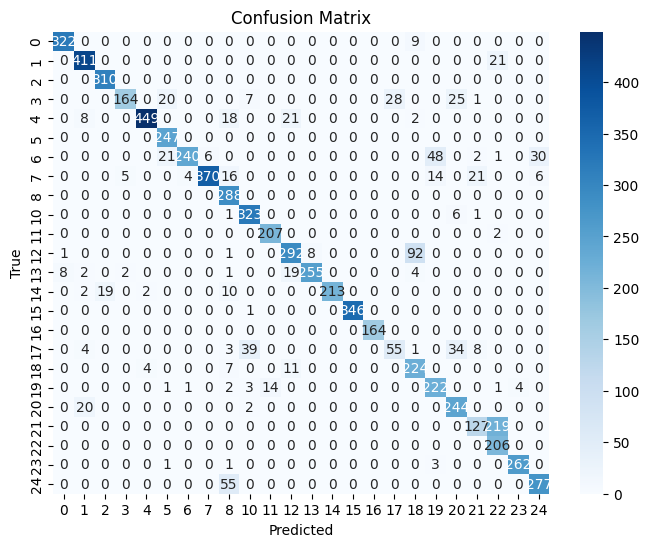

In [108]:
true_labels2 = np.array(test_df['label'])
accuracy2 = accuracy_score(true_labels2, predicted_labels2)
cm2 = confusion_matrix(true_labels2, predicted_labels2)
print(f'Accuracy: {accuracy2:.2f}')
class_labels2 = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_rep2 = classification_report(true_labels2, predicted_labels2)
print(f'Classification Report:\n{classification_rep2}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels2, yticklabels=class_labels2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model3

In [280]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model3.add(MaxPool2D((2, 2), strides=2, padding='same'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model3.add(MaxPool2D((2, 2), strides=2, padding='same'))
model3.add(BatchNormalization())
model3.add(Flatten()) 
model3.add(Dense(1024,activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(256,activation='relu'))
model3.add(Dense(24, activation='softmax'))

In [281]:
model3.compile(optimizer=Adam(learning_rate=0.0115) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model3.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_157 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_85 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_125 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_158 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 7, 7, 64)       

In [282]:
history3 = model3.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
429/429 [==============================] - 10s 22ms/step - loss: 3.0980 - accuracy: 0.1710 - val_loss: 3.1885 - val_accuracy: 0.1181 - lr: 0.0115
Epoch 2/10
429/429 [==============================] - 9s 21ms/step - loss: 1.8289 - accuracy: 0.3726 - val_loss: 1.9741 - val_accuracy: 0.2532 - lr: 0.0115
Epoch 3/10
429/429 [==============================] - 9s 21ms/step - loss: 1.2102 - accuracy: 0.5714 - val_loss: 1.7645 - val_accuracy: 0.4745 - lr: 0.0115
Epoch 4/10
429/429 [==============================] - 9s 21ms/step - loss: 0.9051 - accuracy: 0.6854 - val_loss: 0.4354 - val_accuracy: 0.8567 - lr: 0.0115
Epoch 5/10
429/429 [==============================] - 9s 21ms/step - loss: 0.7705 - accuracy: 0.7390 - val_loss: 0.4583 - val_accuracy: 0.8424 - lr: 0.0115
Epoch 6/10
429/429 [==============================] - 9s 21ms/step - loss: 0.6882 - accuracy: 0.7773 - val_loss: 0.3270 - val_accuracy: 0.8760 - lr: 0.0115
Epoch 7/10
429/429 [==============================] - 9s 21ms/s

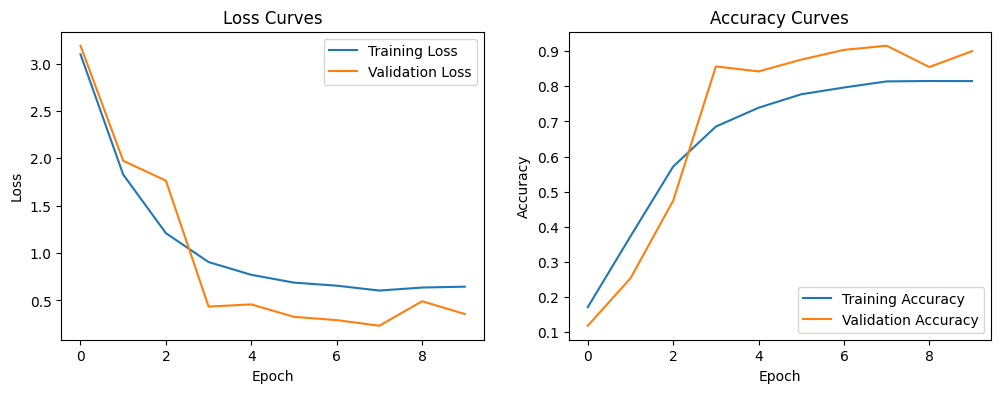

In [283]:
plotTrainCurves(history3)

In [284]:
model3.save("./models/model3.h5")

In [285]:
predictions3 = model3.predict(x_test)
predicted_labels3 = np.argmax(predictions3, axis=1)

225/225 [==============================] - 1s 5ms/step


In [286]:
for i in range(len(predicted_labels3)):
    if predicted_labels3[i] > 8:
        predicted_labels3[i]+=1
print(predicted_labels3)

[ 6  1 10 ...  2  4  2]


Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       0.95      1.00      0.98       432
           2       0.90      0.99      0.94       310
           3       0.98      0.91      0.94       245
           4       1.00      0.98      0.99       498
           5       1.00      0.92      0.96       247
           6       0.83      0.81      0.82       348
           7       0.93      1.00      0.96       436
           8       0.99      0.95      0.97       288
          10       0.90      0.94      0.92       331
          11       1.00      0.99      1.00       209
          12       0.80      0.98      0.88       394
          13       0.93      0.54      0.68       291
          14       0.77      0.98      0.86       246
          15       0.90      1.00      0.95       347
          16       0.99      1.00      1.00       164
          17       0.83      0.73      0.77

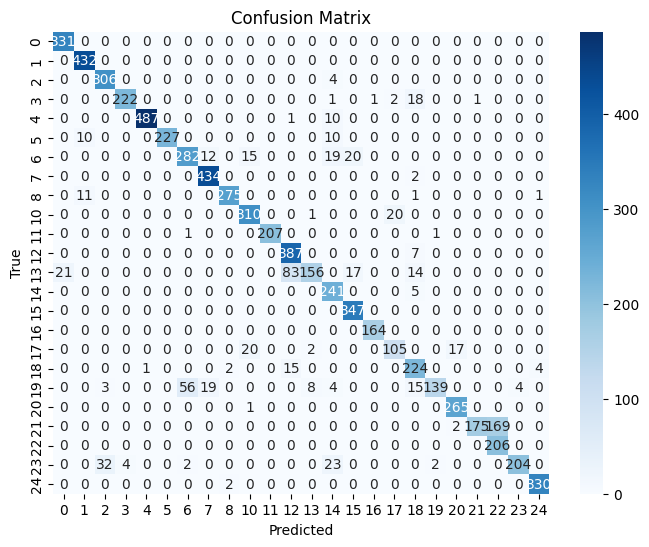

In [287]:
true_labels3 = np.array(test_df['label'])
accuracy3 = accuracy_score(true_labels3, predicted_labels3)
cm3 = confusion_matrix(true_labels3, predicted_labels3)
print(f'Accuracy: {accuracy3:.2f}')
class_labels3 = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_rep3 = classification_report(true_labels3, predicted_labels3)
print(f'Classification Report:\n{classification_rep3}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels3, yticklabels=class_labels3)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model4


In [407]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(24, activation='softmax'))

In [408]:
model4.compile(optimizer=Adam(learning_rate=0.00155) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model4.summary()

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_167 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_241 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_168 (MaxPooli  (None, 5, 5, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_242 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_169 (MaxPooli  (None, 1, 1, 128)     

In [409]:
history4 = model4.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
429/429 [==============================] - 11s 23ms/step - loss: 1.6895 - accuracy: 0.4511 - val_loss: 1.2478 - val_accuracy: 0.6085 - lr: 0.0016
Epoch 2/10
429/429 [==============================] - 9s 21ms/step - loss: 0.7549 - accuracy: 0.7362 - val_loss: 0.9607 - val_accuracy: 0.6792 - lr: 0.0016
Epoch 3/10
429/429 [==============================] - 9s 22ms/step - loss: 0.5438 - accuracy: 0.8149 - val_loss: 0.2931 - val_accuracy: 0.8986 - lr: 0.0016
Epoch 4/10
429/429 [==============================] - 9s 21ms/step - loss: 0.4496 - accuracy: 0.8520 - val_loss: 0.6277 - val_accuracy: 0.8097 - lr: 0.0016
Epoch 5/10
428/429 [============================>.] - ETA: 0s - loss: 0.3870 - accuracy: 0.8708
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007750000222586095.
429/429 [==============================] - 9s 22ms/step - loss: 0.3866 - accuracy: 0.8708 - val_loss: 0.6557 - val_accuracy: 0.8207 - lr: 0.0016
Epoch 6/10
429/429 [==============================] - 9s 2

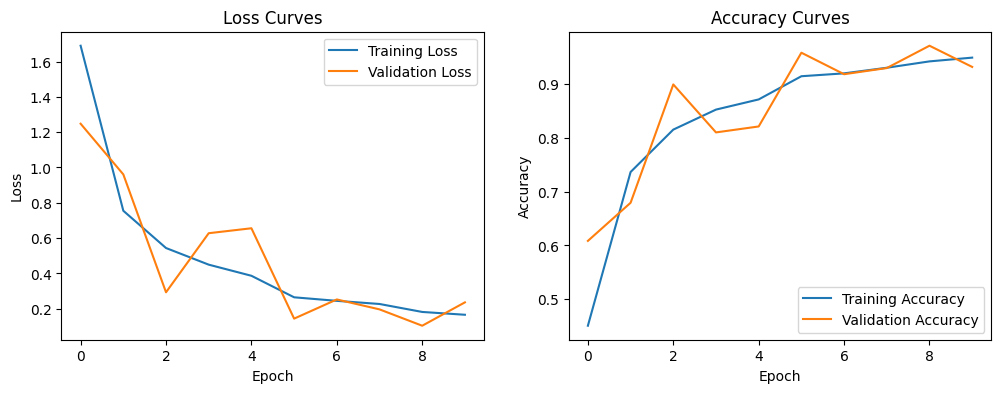

In [410]:
plotTrainCurves(history4)

In [411]:
model4.save("./models/model4.h5")

In [412]:
predictions4 = model4.predict(x_test)
predicted_labels4 = np.argmax(predictions4, axis=1)

225/225 [==============================] - 1s 3ms/step


In [413]:
for i in range(len(predicted_labels4)):
    if predicted_labels4[i] > 8:
        predicted_labels4[i]+=1
print(predicted_labels4)

[ 6  5 10 ... 14  4 14]


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       331
           1       1.00      1.00      1.00       432
           2       1.00      0.80      0.89       310
           3       1.00      0.93      0.97       245
           4       1.00      0.87      0.93       498
           5       1.00      0.99      0.99       247
           6       1.00      0.59      0.74       348
           7       0.71      1.00      0.83       436
           8       1.00      0.99      0.99       288
          10       1.00      0.91      0.95       331
          11       0.93      1.00      0.96       209
          12       0.92      0.99      0.95       394
          13       1.00      0.94      0.97       291
          14       0.80      1.00      0.89       246
          15       1.00      1.00      1.00       347
          16       0.99      1.00      1.00       164
          17       0.95      1.00      0.98

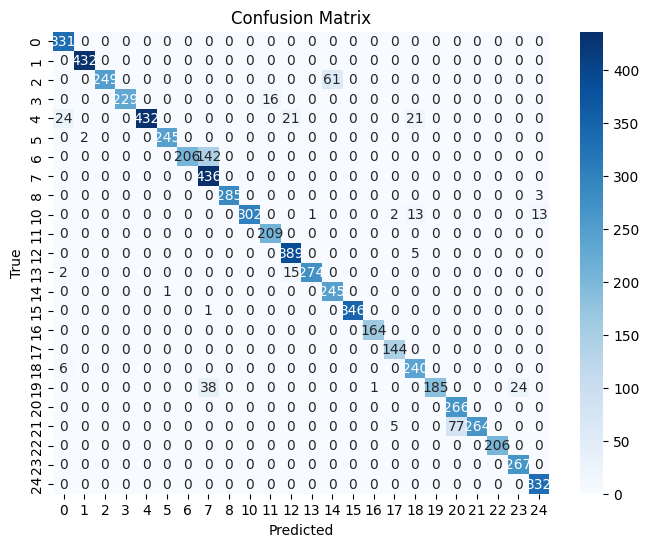

In [414]:
true_labels4 = np.array(test_df['label'])
accuracy4 = accuracy_score(true_labels4, predicted_labels4)
cm4 = confusion_matrix(true_labels4, predicted_labels4)
print(f'Accuracy: {accuracy4:.2f}')
class_labels4 = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_rep4 = classification_report(true_labels4, predicted_labels4)
print(f'Classification Report:\n{classification_rep4}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels4, yticklabels=class_labels4)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# loading all the models for ensambles
model_1 = load_model('models/model1.h5')
model_2 = load_model('models/model2.h5')
model_3 = load_model('models/model3.h5')
model_4 = load_model('models/model4.h5')


In [22]:
# predictions of each model
preds1 = model_1.predict(x_test)
preds2 = model_2.predict(x_test)
preds3 = model_3.predict(x_test)
preds4 = model_4.predict(x_test)

225/225 [==============================] - 1s 2ms/step


In [23]:
# Perform hard voting
ensemble_preds = np.argmax(np.sum([preds1, preds2, preds3, preds4], axis=0), axis=1)

In [24]:
for i in range(len(ensemble_preds)):
    if ensemble_preds[i] > 8:
        ensemble_preds[i]+=1
print(ensemble_preds)

[ 6  5 10 ...  2  4  2]


In [25]:
# Calculate accuracy on the test set
true_labelsE = np.array(test_df['label'])
ensemble_accuracy = accuracy_score(true_labelsE, ensemble_preds)
print(f'Ensemble Accuracy: {ensemble_accuracy}')

Ensemble Accuracy: 0.9817345231455661


Final Model

In [64]:
modelF = Sequential()
modelF.add(Conv2D(70 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
modelF.add(BatchNormalization())
modelF.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelF.add(Dropout(0.3))
modelF.add(BatchNormalization())
modelF.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF.add(Conv2D(20 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelF.add(BatchNormalization())
modelF.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF.add(Flatten())
modelF.add(Dense(units = 256 , activation = 'relu'))
modelF.add(Dropout(0.3))

modelF.add(Dense(units = 24 , activation = 'softmax'))

In [65]:
modelF.compile(optimizer=Adam(learning_rate=0.002) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
modelF.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 70)        700       
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 70)       280       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 50)        31550     
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_22 (Bat  (None, 14, 14, 50)      

In [66]:
historyF = modelF.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 10 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 9s 39ms/step - loss: 1.1574 - accuracy: 0.6331 - val_loss: 3.5557 - val_accuracy: 0.1334 - lr: 0.0020
Epoch 2/10
215/215 [==============================] - 7s 35ms/step - loss: 0.2484 - accuracy: 0.9162 - val_loss: 1.3864 - val_accuracy: 0.5434 - lr: 0.0020
Epoch 3/10
215/215 [==============================] - 7s 35ms/step - loss: 0.1328 - accuracy: 0.9560 - val_loss: 0.0842 - val_accuracy: 0.9735 - lr: 0.0020
Epoch 4/10
215/215 [==============================] - 8s 35ms/step - loss: 0.0942 - accuracy: 0.9690 - val_loss: 0.3014 - val_accuracy: 0.8858 - lr: 0.0020
Epoch 5/10
214/215 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9751
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
215/215 [==============================] - 7s 34ms/step - loss: 0.0755 - accuracy: 0.9752 - val_loss: 0.1581 - val_accuracy: 0.9586 - lr: 0.0020
Epoch 6/10
215/215 [==============================] - 7s 35

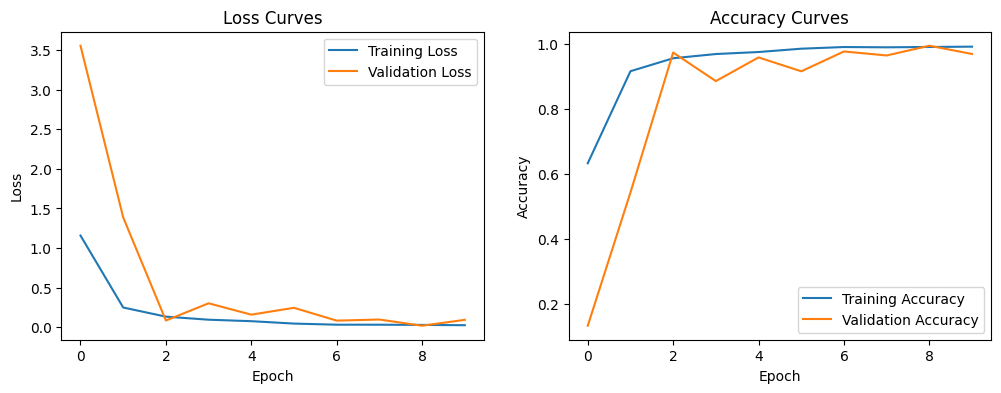

In [67]:
plotTrainCurves(historyF)

In [68]:
predictionsF = modelF.predict(x_test)
predicted_labelsF = np.argmax(predictionsF, axis=1)

225/225 [==============================] - 1s 3ms/step


In [69]:
for i in range(len(predicted_labelsF)):
    if predicted_labelsF[i] > 8:
        predicted_labelsF[i]+=1
print(predicted_labelsF)

[ 6  5 10 ...  2  4  2]


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       331
           1       1.00      1.00      1.00       432
           2       0.95      1.00      0.98       310
           3       0.99      0.96      0.98       245
           4       0.97      1.00      0.98       498
           5       1.00      1.00      1.00       247
           6       1.00      0.88      0.94       348
           7       1.00      0.99      0.99       436
           8       0.98      1.00      0.99       288
          10       1.00      0.98      0.99       331
          11       0.95      1.00      0.98       209
          12       0.98      1.00      0.99       394
          13       1.00      0.90      0.95       291
          14       1.00      0.94      0.97       246
          15       0.95      1.00      0.97       347
          16       1.00      1.00      1.00       164
          17       1.00      0.75      0.86

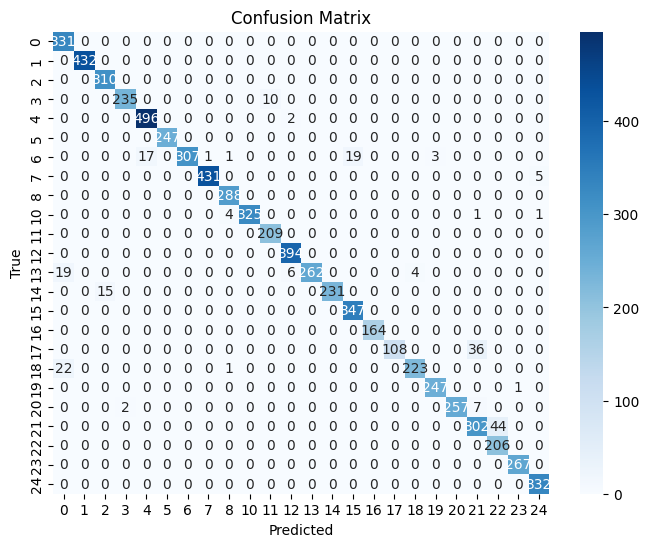

In [70]:
true_labelsF = np.array(test_df['label'])
accuracyF = accuracy_score(true_labelsF, predicted_labelsF)
cmF = confusion_matrix(true_labelsF, predicted_labelsF)
print(f'Accuracy: {accuracyF:.2f}')
class_labelsF = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_repF = classification_report(true_labelsF, predicted_labelsF)
print(f'Classification Report:\n{classification_repF}')
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt="d", cmap="Blues", xticklabels=class_labelsF, yticklabels=class_labelsF)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Tuning the model for getting better accuracy.

In [49]:
modelF_1 = Sequential()
modelF_1.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1))) #Increased the number of layers
modelF_1.add(BatchNormalization())
modelF_1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF_1.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelF_1.add(Dropout(0.2))#changed the dropout to 0.2
modelF_1.add(BatchNormalization())
modelF_1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF_1.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')) #Increased the number of layers
modelF_1.add(BatchNormalization())
modelF_1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

modelF_1.add(Flatten())
modelF_1.add(Dense(units = 512 , activation = 'relu'))  #Changed the units to 512
modelF_1.add(Dropout(0.3))

modelF_1.add(Dense(units = 24 , activation = 'softmax'))

In [50]:
modelF_1.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy']) #Changed the learning rate to 0.0001
modelF_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_28 (Bat  (None, 14, 14, 50)      

In [51]:
historyF_1 = modelF_1.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction]) #Increased the number of epochs for better training.

Epoch 1/20
215/215 [==============================] - 10s 40ms/step - loss: 1.0455 - accuracy: 0.6697 - val_loss: 3.3227 - val_accuracy: 0.1393 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 9s 42ms/step - loss: 0.2262 - accuracy: 0.9244 - val_loss: 1.5415 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 8s 39ms/step - loss: 0.1034 - accuracy: 0.9655 - val_loss: 0.0799 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 8s 39ms/step - loss: 0.0688 - accuracy: 0.9773 - val_loss: 0.0199 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 8s 39ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0321 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9885
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 8s 3

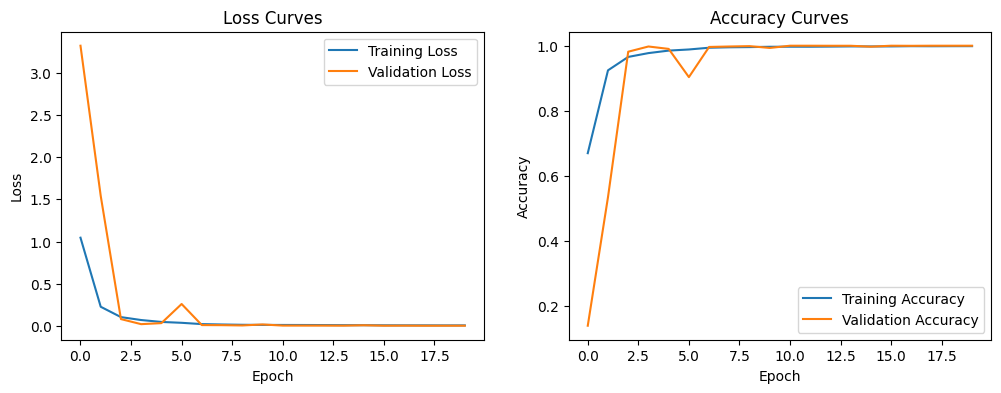

In [52]:
plotTrainCurves(historyF_1)

In [53]:
modelF_1.save("./models/modelFinal.h5")

In [54]:
predictionsF_1 = modelF_1.predict(x_test)
predicted_labelsF_1 = np.argmax(predictionsF_1, axis=1)

225/225 [==============================] - 1s 3ms/step


In [55]:
for i in range(len(predicted_labelsF_1)):
    if predicted_labelsF_1[i] > 8:
        predicted_labelsF_1[i]+=1
print(predicted_labelsF_1)

[ 6  5 10 ...  2  4  2]


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      1.00      1.00

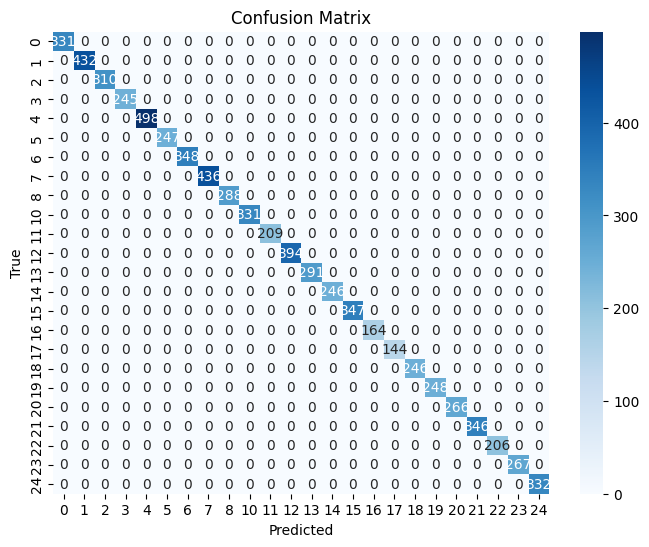

In [56]:
true_labelsF_1 = np.array(test_df['label'])
accuracyF_1 = accuracy_score(true_labelsF_1, predicted_labelsF_1)
cmF_1 = confusion_matrix(true_labelsF_1, predicted_labelsF_1)
print(f'Accuracy: {accuracyF_1:.2f}')
class_labelsF_1 = [0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
classification_repF_1 = classification_report(true_labelsF_1, predicted_labelsF_1)
print(f'Classification Report:\n{classification_repF_1}')
plt.figure(figsize=(8, 6))
sns.heatmap(cmF_1, annot=True, fmt="d", cmap="Blues", xticklabels=class_labelsF_1, yticklabels=class_labelsF_1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
final_model = load_model("./models/modelFinal.h5")

In [23]:
test_predictions = final_model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions

225/225 [==============================] - 1s 6ms/step


array([6, 5, 9, ..., 2, 4, 2], dtype=int64)

In [24]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 8:
        test_predictions[i]+=1
print(test_predictions)

[ 6  5 10 ...  2  4  2]


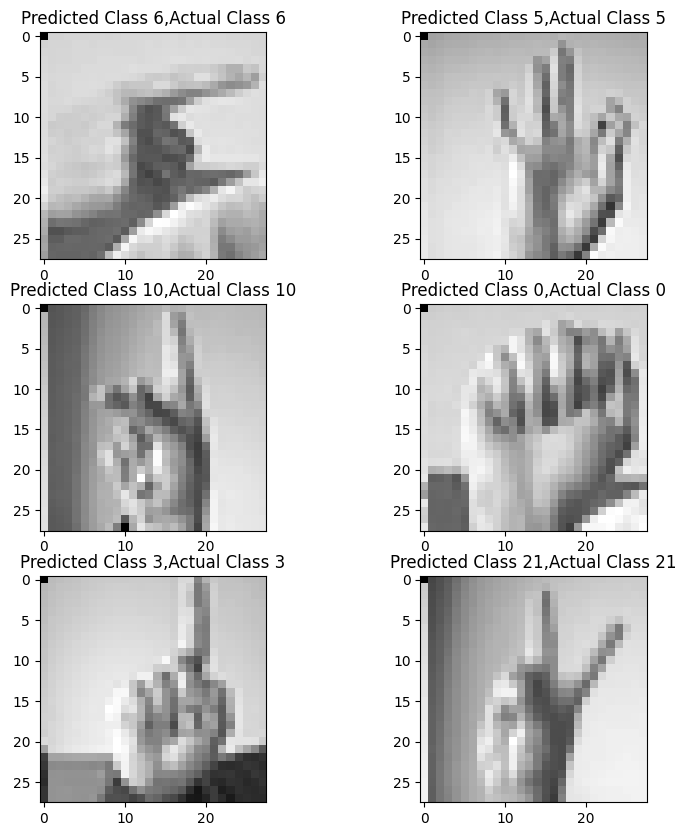

In [30]:
true_labels_test = np.array(test_df['label'])
correct = np.nonzero(test_predictions == true_labels_test)[0]
i = 0
plt.figure(figsize=(9, 10))
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(test_predictions[c], test_predictions[c]))
    # plt.tight_layout()
    i += 1